In [2]:
# Dependencies 
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter, AutoMinorLocator)
from scipy.stats import linregress
from sklearn import linear_model
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import pandas as pd
%matplotlib inline
import numpy as np
import requests
import gmaps
import time
import json
import re


In [3]:
# ZHVI All Homes (SFR, Condo/Co-op) Time Series ($) (by ZIP code)
csv_home_values = "../Data/Zip_Zhvi_AllHomes.csv"

# Median Sale Price - Seasonally Adjusted ($) (by ZIP code)
csv_home_sales = "../Data/Sale_Prices_Zip.csv"

# Monthly Home Sales (Number, Raw) (by ZIP code)
csv_number_sales = "../Data/Sale_Counts_Zip.csv"

# Foreclosure Resales (%) (by ZIP code)
csv_foreclosure_resales = "../Data/SalesPrevForeclosed_Share_Zip.csv"

home_values = pd.read_csv(csv_home_values, encoding="ISO-8859-1")
home_sales = pd.read_csv(csv_home_sales, encoding="ISO-8859-1")
number_sales = pd.read_csv(csv_number_sales, encoding="ISO-8859-1")
foreclosure_resales = pd.read_csv(csv_foreclosure_resales, encoding="ISO-8859-1")

In [4]:
# Python Dictionary to translate US States to Two letter codes
# Dictionary obtained from rogerallen (https://gist.github.com/rogerallen/1583593)
us_state_abbrev = {
    'Alabama': 'AL','Alaska': 'AK','Arizona': 'AZ','Arkansas': 'AR','California': 'CA',
    'Colorado': 'CO','Connecticut': 'CT','Delaware': 'DE','District of Columbia': 'DC',
    'Florida': 'FL','Georgia': 'GA','Hawaii': 'HI','Idaho': 'ID','Illinois': 'IL',
    'Indiana': 'IN','Iowa': 'IA','Kansas': 'KS','Kentucky': 'KY','Louisiana': 'LA',
    'Maine': 'ME','Maryland': 'MD','Massachusetts': 'MA','Michigan': 'MI','Minnesota': 'MN',
    'Mississippi': 'MS','Missouri': 'MO','Montana': 'MT','Nebraska': 'NE','Nevada': 'NV',
    'New Hampshire': 'NH','New Jersey': 'NJ','New Mexico': 'NM','New York': 'NY',
    'North Carolina': 'NC','North Dakota': 'ND','Northern Mariana Islands':'MP','Ohio': 'OH',
    'Oklahoma': 'OK','Oregon': 'OR','Palau': 'PW','Pennsylvania': 'PA','Puerto Rico': 'PR',
    'Rhode Island': 'RI','South Carolina': 'SC','South Dakota': 'SD','Tennessee': 'TN',
    'Texas': 'TX','Utah': 'UT','Vermont': 'VT','Virgin Islands': 'VI','Virginia': 'VA',
    'Washington': 'WA','West Virginia': 'WV','Wisconsin': 'WI','Wyoming': 'WY',
}

# Rename StateName columns
home_values = home_values.rename(columns={"RegionName":"ZIP Code",
                                          "2008-01":"2008-01_ZHVI",
                                          "2008-02":"2008-02_ZHVI"})
home_sales = home_sales.rename(columns={"RegionName":"ZIP Code",
                                        "StateName":"State"})
number_sales = number_sales.rename(columns={"RegionName":"ZIP Code",
                                            "StateName":"State",
                                            "seasAdj":"seasAdj_NS"})
foreclosure_resales = foreclosure_resales.rename(columns={"RegionName":"ZIP Code",
                                                          "StateName":"State"})

# Translate states into two letter codes for each file and handle errors
try:
    for index, row in home_sales.iterrows():
        state = home_sales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        home_sales.loc[index, "State"] = abbr

    for index, row in number_sales.iterrows():
        state = number_sales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        number_sales.loc[index, "State"] = abbr

    for index, row in foreclosure_resales.iterrows():
        state = foreclosure_resales.loc[index, "State"]
        abbr = us_state_abbrev[state]
        foreclosure_resales.loc[index, "State"] = abbr
except:
    pass

In [5]:
# Merge the home_values, home_sales, number_sales and foreclosure_resales
merge1 = pd.merge(home_values, home_sales, on=["ZIP Code","State","RegionID"], how="outer", suffixes=("_ZHVI", "_MSR"))
merge2 = pd.merge(number_sales, foreclosure_resales, on=["ZIP Code","State","RegionID"], how="outer", suffixes=("_NS", "_FR"))
main_data = pd.merge(merge1, merge2, on=["ZIP Code","State","RegionID"], how="outer")

In [6]:
# Function to get mean of the columns from minimum month and year to maximum month and year with different suffixes
# Used regular expressions
def findavg(data,year,suffix):
    x = []
    for i in data.columns:
        # Find all words matching the year and suffix and append to x
        y = (re.findall(f'^{year}-([0-9][0-9])_{suffix}',i))
        [x.append(int(i)) for i in y]
    min_col = data.columns.get_loc(f"{year}-{min(x):02d}_{suffix}")
    max_col = data.columns.get_loc(f"{year}-{max(x):02d}_{suffix}")
    data[f"{year}_Avg_{suffix}"] = data.iloc[:,min_col:max_col+1].mean(axis=1)
    return data[f"{year}_Avg_{suffix}"]

# Function to get sum of the columns from minimum month, year to maximum month, year with different suffixes
# Used regular expressions
def findsum(data,year,suffix):
    x = []
    for i in data.columns:
        # Find all words matching the year and suffix and append to x
        y = (re.findall(f'^{year}-([0-9][0-9])_{suffix}',i))
        [x.append(int(i)) for i in y]
    min_col = data.columns.get_loc(f"{year}-{min(x):02d}_{suffix}")
    max_col = data.columns.get_loc(f"{year}-{max(x):02d}_{suffix}")
    data[f"{year}_Avg_{suffix}"] = data.iloc[:,min_col:max_col+1].sum(axis=1)
    return data[f"{year}_Avg_{suffix}"]

In [7]:
# Grabbed the 'RegionID', 'ZIP Code', 'City', 'State', 'CountyName' columns from main_data
new_main_data = main_data[['RegionID', 'ZIP Code', 'City', 'State', 'CountyName']]
new_main_data.head()

,RegionID,ZIP Code,City,State,CountyName
0,84654,60657,Chicago,IL,Cook County
1,61637,10023,New York,NY,New York County
2,91982,77494,Katy,TX,Harris County
3,84616,60614,Chicago,IL,Cook County
4,91940,77449,Katy,TX,Harris County


In [8]:
# Join suffixes "ZHVI","MSR" and "FR" across different years by mean to new_main_data
years = [i for i in range(2008,2020,1)]
suffixes = ["ZHVI","MSR","FR"]

for year in years:
    for suffix in suffixes:
        new_main_data = new_main_data.join(findavg(main_data,year,suffix))
        
    # Join suffix "NS" across different years by mean to new_main_data
    new_main_data = new_main_data.join(findsum(main_data,year,"NS"))
        
new_main_data.head()

,RegionID,ZIP Code,City,State,CountyName,2008_Avg_ZHVI,2008_Avg_MSR,2008_Avg_FR,2008_Avg_NS,2009_Avg_ZHVI,...,2017_Avg_FR,2017_Avg_NS,2018_Avg_ZHVI,2018_Avg_MSR,2018_Avg_FR,2018_Avg_NS,2019_Avg_ZHVI,2019_Avg_MSR,2019_Avg_FR,2019_Avg_NS
0,84654,60657,Chicago,IL,Cook County,479900.645833,376410.0,0.00000,1469.0,466041.694444,...,0.004208,2556.0,4.886200e+05,3.704417e+05,0.005367,2157.0,4.835098e+05,4.097091e+05,0.006700,1442.0
1,61637,10023,New York,NY,New York County,NaN,NaN,NaN,0.0,833515.733333,...,NaN,904.0,1.216848e+06,1.115458e+06,NaN,930.0,1.176796e+06,1.146527e+06,NaN,791.0
2,91982,77494,Katy,TX,Harris County,267059.388889,243020.0,0.03512,792.0,267583.416667,...,0.002967,3092.0,3.329190e+05,3.316750e+05,0.001367,3047.0,3.340930e+05,3.250500e+05,0.007025,2424.0
3,84616,60614,Chicago,IL,Cook County,606633.729167,NaN,NaN,0.0,594972.111111,...,0.002430,2154.0,6.361214e+05,4.334167e+05,0.001183,2369.0,6.297365e+05,5.015000e+05,0.006750,1683.0
4,91940,77449,Katy,TX,Harris County,125067.777778,NaN,0.24388,1257.0,119876.111111,...,0.012083,1885.0,1.760530e+05,1.764667e+05,0.003492,1897.0,1.830033e+05,1.878727e+05,0.011450,1791.0


In [9]:
# Group the data by State and agrregated them by there mean across the zipcodes.
state_data_1 = new_main_data[
                     ['State', '2008_Avg_ZHVI','2009_Avg_ZHVI', '2010_Avg_ZHVI', '2011_Avg_ZHVI',
                      '2012_Avg_ZHVI', '2013_Avg_ZHVI', '2014_Avg_ZHVI', '2015_Avg_ZHVI', '2016_Avg_ZHVI',
                      '2017_Avg_ZHVI', '2018_Avg_ZHVI', '2019_Avg_ZHVI', '2008_Avg_MSR','2009_Avg_MSR', 
                      '2010_Avg_MSR', '2011_Avg_MSR', '2012_Avg_MSR','2013_Avg_MSR', '2014_Avg_MSR', 
                      '2015_Avg_MSR', '2016_Avg_MSR','2017_Avg_MSR', '2018_Avg_MSR', '2019_Avg_MSR', 
                      '2008_Avg_NS','2009_Avg_NS', '2010_Avg_NS', '2011_Avg_NS', '2012_Avg_NS','2013_Avg_NS', 
                      '2014_Avg_NS', '2015_Avg_NS', '2016_Avg_NS','2017_Avg_NS', '2018_Avg_NS', '2019_Avg_NS', 
                      '2008_Avg_FR', '2009_Avg_FR', '2010_Avg_FR', '2011_Avg_FR', '2012_Avg_FR','2013_Avg_FR', 
                      '2014_Avg_FR', '2015_Avg_FR', '2016_Avg_FR','2017_Avg_FR', '2018_Avg_FR', '2019_Avg_FR']
                    ]\
                        .groupby("State")
state_data_1.head()

,State,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,...,2010_Avg_FR,2011_Avg_FR,2012_Avg_FR,2013_Avg_FR,2014_Avg_FR,2015_Avg_FR,2016_Avg_FR,2017_Avg_FR,2018_Avg_FR,2019_Avg_FR
0,IL,479900.645833,466041.694444,445775.916667,423604.722222,412033.055556,421352.583333,4.435987e+05,4.528587e+05,4.686318e+05,...,0.000633,0.000550,0.001392,0.025442,0.016950,0.003683,0.005017,0.004208,0.005367,0.006700
1,NY,NaN,833515.733333,836375.277778,858051.166667,888688.861111,949063.444444,1.068758e+06,1.138190e+06,1.197406e+06,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TX,267059.388889,267583.416667,274168.222222,266745.861111,271493.027778,290686.722222,3.156699e+05,3.346299e+05,3.319498e+05,...,0.038658,0.029625,0.029517,0.010633,0.004033,0.002458,0.003492,0.002967,0.001367,0.007025
3,IL,606633.729167,594972.111111,565302.194444,534765.361111,523258.083333,537427.972222,5.705761e+05,5.916056e+05,6.132054e+05,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.002430,0.001183,0.006750
4,TX,125067.777778,119876.111111,119721.722222,112142.083333,110622.833333,123323.277778,1.395240e+05,1.541215e+05,1.636677e+05,...,0.235167,0.206533,0.189350,0.055933,0.031283,0.013625,0.013442,0.012083,0.003492,0.011450
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4142,AK,327831.027778,324280.194444,323373.222222,325451.444444,329033.250000,338913.694444,3.476687e+05,3.613371e+05,3.714191e+05,...,0.030508,0.016675,0.004942,0.003333,0.000000,0.002450,0.004667,0.006150,0.000000,0.000000
4776,VT,201571.125000,195480.138889,191858.500000,186682.972222,183282.500000,179291.527778,1.767206e+05,1.750010e+05,1.720527e+05,...,0.034192,0.044183,0.037383,0.050175,0.050342,0.091842,0.049717,0.047750,0.091308,0.091160
5059,VT,244714.916667,245448.555556,256923.388889,261716.638889,257313.027778,262453.583333,2.673014e+05,2.732943e+05,2.779626e+05,...,0.000000,0.005950,0.005075,0.001700,0.011475,0.002317,0.000000,0.000000,0.017750,0.005682
6308,VT,174988.347222,170009.972222,167350.222222,165775.555556,164736.638889,163483.805556,1.632336e+05,1.654972e+05,1.672857e+05,...,0.032742,0.025933,0.021242,0.079033,0.049925,0.060642,0.012625,0.042533,0.038950,0.024813


In [10]:
# Calculate average Zillow Home Value Index (ZHVI) per state
mean_zhvi = state_data_1[['State', '2008_Avg_ZHVI','2009_Avg_ZHVI', '2010_Avg_ZHVI', '2011_Avg_ZHVI', '2012_Avg_ZHVI',
                          '2013_Avg_ZHVI', '2014_Avg_ZHVI', '2015_Avg_ZHVI', '2016_Avg_ZHVI', '2017_Avg_ZHVI',
                          '2018_Avg_ZHVI', '2019_Avg_ZHVI']].mean()

# Calculate average Median Sales Price (MSR) per state
mean_msr = state_data_1[['State','2008_Avg_MSR','2009_Avg_MSR', '2010_Avg_MSR', '2011_Avg_MSR', '2012_Avg_MSR',
                         '2013_Avg_MSR', '2014_Avg_MSR', '2015_Avg_MSR', '2016_Avg_MSR','2017_Avg_MSR',
                         '2018_Avg_MSR', '2019_Avg_MSR']].mean()

# Calculate total number of sales per state
sum_number_sales = state_data_1[['State','2008_Avg_NS','2009_Avg_NS', '2010_Avg_NS', '2011_Avg_NS', '2012_Avg_NS',
                                 '2013_Avg_NS', '2014_Avg_NS', '2015_Avg_NS', '2016_Avg_NS','2017_Avg_NS',
                                 '2018_Avg_NS', '2019_Avg_NS']].sum()

# Calculate average Foreclosure Resales (FR) per state
mean_fr = state_data_1[['State','2008_Avg_FR', '2009_Avg_FR', '2010_Avg_FR', '2011_Avg_FR', '2012_Avg_FR','2013_Avg_FR', 
                      '2014_Avg_FR', '2015_Avg_FR', '2016_Avg_FR','2017_Avg_FR', '2018_Avg_FR', '2019_Avg_FR']].mean()

# Put state data into dataframe
state_data_2 = pd.merge(mean_zhvi, mean_msr, on='State', how='outer')
state_data_3 = pd.merge(sum_number_sales, mean_fr, on='State', how='outer')
state_data = pd.merge(state_data_2, state_data_3, on='State', how='outer')

Data Exploration to Show Average U.S Housing Price, Seasonally Adjusted Median Sales Price and Average Number of Home Sales From 2008 To 2019

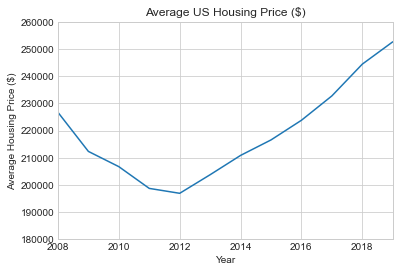

In [11]:
# Average U.S Housing Price
ave_home_values = [state_data["2008_Avg_ZHVI"].mean(), state_data["2009_Avg_ZHVI"].mean(),state_data["2010_Avg_ZHVI"].mean(),
                  state_data["2011_Avg_ZHVI"].mean(),state_data["2012_Avg_ZHVI"].mean(), state_data["2013_Avg_ZHVI"].mean(),
                  state_data["2014_Avg_ZHVI"].mean(), state_data["2015_Avg_ZHVI"].mean(), state_data["2016_Avg_ZHVI"].mean(),
                  state_data["2017_Avg_ZHVI"].mean(), state_data["2018_Avg_ZHVI"].mean(), state_data["2019_Avg_ZHVI"].mean()]
ave_home_values
years = [2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
plt.title("Average US Housing Price ($)")
plt.xlabel("Year")
plt.ylabel("Average Housing Price ($)")
plt.ylim(180000,260000)
plt.xlim(2008,2019)
plt.plot(years,ave_home_values)

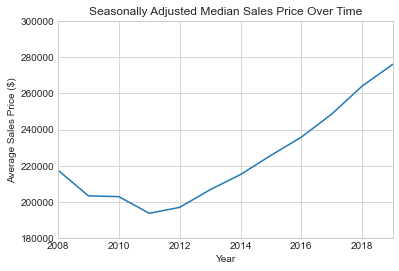

In [12]:
# Plot Of U.S Seasonally Adjusted Median Sales Price From 2008 To 2019
ave_sales_price = [state_data["2008_Avg_MSR"].mean(), state_data["2009_Avg_MSR"].mean(),state_data["2010_Avg_MSR"].mean(),
                  state_data["2011_Avg_MSR"].mean(),state_data["2012_Avg_MSR"].mean(), state_data["2013_Avg_MSR"].mean(),
                  state_data["2014_Avg_MSR"].mean(), state_data["2015_Avg_MSR"].mean(), state_data["2016_Avg_MSR"].mean(),
                  state_data["2017_Avg_MSR"].mean(), state_data["2018_Avg_MSR"].mean(), state_data["2019_Avg_MSR"].mean()]
plt.title("Seasonally Adjusted Median Sales Price Over Time")
plt.xlabel("Year")
plt.ylabel("Average Sales Price ($)")
plt.ylim(180000,300000)
plt.xlim(2008,2019)
plt.plot(years,ave_sales_price)

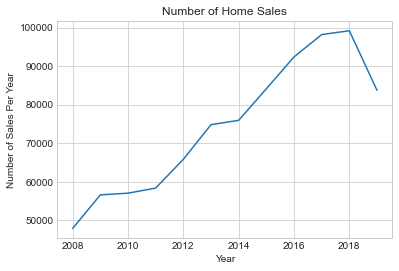

In [13]:
# Plot of Avg Number of Sales Per Month
ave_home_sales = [state_data["2008_Avg_NS"].mean(), state_data["2009_Avg_NS"].mean(),state_data["2010_Avg_NS"].mean(),
                  state_data["2011_Avg_NS"].mean(),state_data["2012_Avg_NS"].mean(), state_data["2013_Avg_NS"].mean(),
                  state_data["2014_Avg_NS"].mean(), state_data["2015_Avg_NS"].mean(), state_data["2016_Avg_NS"].mean(),
                  state_data["2017_Avg_NS"].mean(), state_data["2018_Avg_NS"].mean(), state_data["2019_Avg_NS"].mean()]
plt.title("Number of Home Sales")
plt.xlabel("Year")
plt.ylabel("Number of Sales Per Year")
plt.plot(years, ave_home_sales)

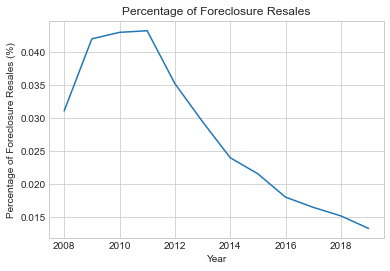

In [14]:
# Plot of Avg Foreclosure Resales
ave_foreclosure_resales = [state_data["2008_Avg_FR"].mean(), state_data["2009_Avg_FR"].mean(),state_data["2010_Avg_FR"].mean(),
                  state_data["2011_Avg_FR"].mean(),state_data["2012_Avg_FR"].mean(), state_data["2013_Avg_FR"].mean(),
                  state_data["2014_Avg_FR"].mean(), state_data["2015_Avg_FR"].mean(), state_data["2016_Avg_FR"].mean(),
                  state_data["2017_Avg_FR"].mean(), state_data["2018_Avg_FR"].mean(), state_data["2019_Avg_FR"].mean()]
plt.title("Percentage of Foreclosure Resales")
plt.xlabel("Year")
plt.ylabel("Percentage of Foreclosure Resales (%)")
plt.plot(years, ave_foreclosure_resales)

Divorce Rate Across All States in the U.S

In [15]:
#Get divorce-rate and convert to dataframe
divorce_csv = "../Data/divorce-rate.xlsx"

divorce_rate = pd.read_excel(divorce_csv, encoding="ISO-8859-1")

In [16]:
# Translate states into two letter codes and handle errors
try:
    for index, row in divorce_rate.iterrows():
        state = divorce_rate.loc[index, "State"]
        abbr = us_state_abbrev[state]
        divorce_rate.loc[index, "State"] = abbr
except:
    pass

# Set index to "State" and change "Div Rate" to column names
divorce_rate = divorce_rate.set_index("State")
years = [i for i in range(2008,2020,1)]
new_divorce = divorce_rate[years[0:-1]]
[new_divorce.rename(columns = {i:f"{i}_Div Rate"}, inplace = True) \
             for i in range(2008,2020,1)]

# Replace missing values with "np.nan"
new_divorce = new_divorce.replace("---",np.nan)

C:\Users\ADMIN\anaconda3\lib\site-packages\pandas\core\frame.py:4125: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().rename(


In [17]:
# Merged main_data (zillow_data) with new_divorce (divorce data)
merge = state_data.join(new_divorce, on="State")

Unemployment Rate Across All States in the U.S

In [18]:
# Get unemployment_csv and convert to dataframe
unemployment_csv = "../Data/Cleaned_BLS_Unemployment-Rate-by-State_2008-2019_1-11-2020.csv"
unemployment_data = pd.read_csv(unemployment_csv, encoding="ISO-8859-1")

# Rename "State" column and set index on "state"
unemployment_data = unemployment_data.rename(columns={"State Abbreviation":"State"}).set_index("State")

In [19]:
# Grab the numeric column headers, convert to string and concatenate "_unemployment"
unemployment_data = unemployment_data[[str(i) for i in range(2008,2020,1)]]
for i in range(2008,2020,1):
    unemployment_data = unemployment_data.rename(columns={str(i):f"{i}_unemployment"})
unemployment_data.head()

,2008_unemployment,2009_unemployment,2010_unemployment,2011_unemployment,2012_unemployment,2013_unemployment,2014_unemployment,2015_unemployment,2016_unemployment,2017_unemployment,2018_unemployment,2019_unemployment
State,,,,,,,,,,,,
AL,5.72,10.99,10.54,9.62,7.98,7.22,6.76,6.08,5.85,4.43,3.94,3.37
AK,6.71,7.73,7.88,7.57,7.13,7.00,6.87,6.53,6.85,6.94,6.60,6.35
AZ,6.14,9.93,10.35,9.50,8.33,7.74,6.80,6.05,5.40,4.89,4.80,4.93
AR,5.50,7.83,8.19,8.29,7.58,7.22,6.02,5.03,3.95,3.71,3.70,3.57
CA,7.29,11.14,12.23,11.71,10.38,8.94,7.50,6.20,5.48,4.78,4.19,4.13


In [20]:
# Merged main_data (merge) with unemployment_data and round to 2 s.f
biggest_data = merge.join(unemployment_data, on="State").round(2)
biggest_data.head()

,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,...,2010_unemployment,2011_unemployment,2012_unemployment,2013_unemployment,2014_unemployment,2015_unemployment,2016_unemployment,2017_unemployment,2018_unemployment,2019_unemployment
State,,,,,,,,,,,,,,,,,,,,,
AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,265698.32,...,7.88,7.57,7.13,7.00,6.87,6.53,6.85,6.94,6.60,6.35
AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,129905.84,...,10.54,9.62,7.98,7.22,6.76,6.08,5.85,4.43,3.94,3.37
AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,106864.87,...,8.19,8.29,7.58,7.22,6.02,5.03,3.95,3.71,3.70,3.57
AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,245929.41,...,10.35,9.50,8.33,7.74,6.80,6.05,5.40,4.89,4.80,4.93
CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,569431.05,...,12.23,11.71,10.38,8.94,7.50,6.20,5.48,4.78,4.19,4.13


In [21]:
ave_unemployment = [biggest_data["2008_unemployment"].mean(), biggest_data["2009_unemployment"],biggest_data["2010_unemployment"],
                   biggest_data["2011_unemployment"].mean(), biggest_data["2012_unemployment"].mean(),biggest_data["2013_unemployment"].mean(),
                   biggest_data["2014_unemployment"].mean(), biggest_data["2015_unemployment"].mean(), biggest_data["2016_unemployment"].mean(),
                   biggest_data["2017_unemployment"].mean(), biggest_data["2018_unemployment"].mean(),biggest_data["2019_unemployment"].mean() ]

#largest decreases
ct_house_price = [347249.22, 323905.39, 313118.01, 300227.8, 288950.2, 293717.92, 294941.32, 295011.95, 298319.43, 301334.04, 306134.33, 307665]
nj_house_price = [420847, 391781, 380717, 361595, 349549, 354848, 366802, 368909, 370148, 376509, 389348, 394467]
md_house_price = [353504, 319818, 303927, 293502, 286752, 295964, 304431, 305693, 308862, 318141, 328421, 333409]
nm_house_price = [216786, 203819, 199048, 185493, 181807, 181872, 181819, 177094, 179636, 184753, 189075, 197808]
wv_house_price = [105933, 102892, 103330, 98392.6, 96010.1, 95029.8, 93818.4, 88433.7, 88496.3, 88742.7, 91196.2, 93635.2]

#largest increases
dc_house_price = [483599, 458940, 459613, 459279, 467900, 506845, 544902, 563038, 584612, 609987, 634940, 662306]
ca_house_price = [420847, 391781, 380717, 361595, 349549, 354848, 366802, 368909, 370148, 376509, 389348, 394467]
co_house_price = [253619, 245396, 241199, 237453, 239758, 255112, 270234, 292758, 313756, 331519, 355129, 370923]
wa_house_price = [301550, 274495, 262044, 241962, 235502, 252028, 267069, 286111, 310318, 339949, 372879, 384769]
ma_house_price = [386248, 364575, 365931, 354750, 349036, 366043, 385413, 403680, 414750, 430518, 451397, 459662]

y1 = ct_house_price
y2 = nj_house_price
y3 = md_house_price
y4 = nm_house_price
y5 = wv_house_price

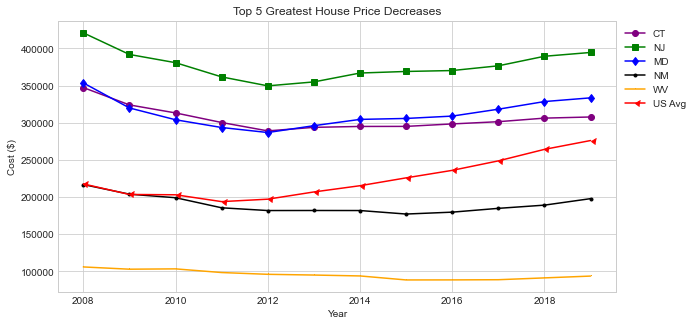

In [22]:
# Plot of Greatest Decrease
plt.figure(figsize=(10,5))
plt.plot(years, y1,marker='o', color="purple",label="CT")
plt.plot(years,y2,marker='s',color="green",label="NJ")
plt.plot(years,y3,marker='d',color="blue", label="MD")
plt.plot(years,y4,marker='.',color="black",label="NM")
plt.plot(years,y5,marker=',',color='orange',label="WV")
plt.plot(years, ave_sales_price, marker=4, color="red", label="US Avg")
plt.title("Top 5 Greatest House Price Decreases")
plt.xlabel("Year")
plt.ylabel("Cost ($)")
plt.legend(bbox_to_anchor=(1, 1), loc='best',
           ncol=1, 
           #mode="expand", borderaxespad=0.
          )

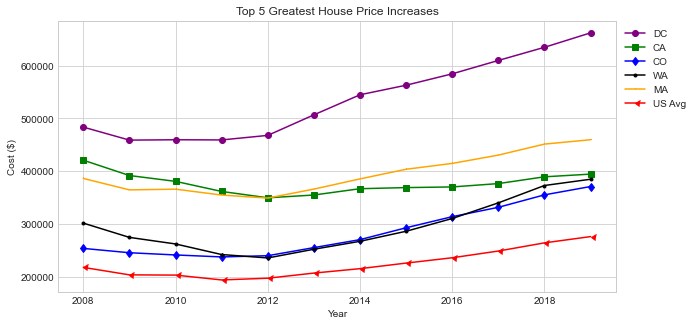

In [23]:
# Plot of Greatest Increase
y6 = dc_house_price
y7 = ca_house_price
y8 = co_house_price
y9 = wa_house_price
y10 = ma_house_price


plt.figure(figsize=(10,5))
plt.plot(years, y6, marker='o', color="purple",label="DC")
plt.plot(years, y7, marker='s',color="green",label="CA")
plt.plot(years, y8, marker='d',color="blue", label="CO")
plt.plot(years, y9, marker='.',color="black",label="WA")
plt.plot(years, y10, marker=',',color='orange',label="MA")
plt.plot(years,ave_sales_price, marker=4, color="red", label="US Avg")
plt.title("Top 5 Greatest House Price Increases")
plt.xlabel("Year")
plt.ylabel("Cost ($)")
plt.legend(bbox_to_anchor=(1, 1), loc='best',
           ncol=1)

Loans Across All States in the U.S

In [24]:
# Get the sheets named "studentloan" and "total" from the excel worksheet
areaReport_csv = "../Data/area_report_by_year.xlsx"
sheetname = ["studentloan", "total"]
df = [" ", " "]

for i in range(len(sheetname)):
    df[i] = pd.read_excel(areaReport_csv, sheet_name=sheetname[i], encoding="ISO-8859-1")
    df[i] = df[i].iloc[2:len(df[i])-1,:]
    # store the header
    xls_header = df[i].iloc[0]
    df[i] = df[i][1:]
    # Use the stored header to name the columns
    df[i].columns = xls_header
    df[i] = df[i].set_index("state")
    df[i].rename_axis(None).index.name

# Unpack "df" list and assign the dataframes to variables
studentLoan_data = df[0]
totalLoan_data = df[1]

# Remove "Q4_" and concatenate "_studentloan" to column names in both dataframes
studentLoan_data = studentLoan_data[["Q4_"+str(i) for i in range(2008,2019,1)]]
totalLoan_data = totalLoan_data[["Q4_"+str(i) for i in range(2008,2019,1)]]
for i in range(2008,2019,1):
    studentLoan_data = studentLoan_data.rename(columns={f"Q4_{i}":f"{i}_studentLoan"})
    totalLoan_data = totalLoan_data.rename(columns={f"Q4_{i}":f"{i}_totalLoan"})
studentLoan_data.head()
totalLoan_data.head()

2,2008_totalLoan,2009_totalLoan,2010_totalLoan,2011_totalLoan,2012_totalLoan,2013_totalLoan,2014_totalLoan,2015_totalLoan,2016_totalLoan,2017_totalLoan,2018_totalLoan
state,,,,,,,,,,,
AK,54110,53140,52730,48440,54740,54000,54330,56050,57040,57850,58550
AL,35540,34180,33590,34390,34370,33380,33760,34210,34780,36060,36780
AR,28940,27990,27470,28910,29480,29030,29430,30020,30820,32220,32790
AZ,65870,60200,54320,52210,48890,46950,47230,47630,48590,51300,53060
CA,86940,81410,74960,72320,68970,65440,66140,65740,66970,70100,71860


In [25]:
# Note => State "P.R" was dropped from dataframe due to missing values
# Merge studentloan and totalloan and round to 2 s.f
latest_merge = biggest_data.join(studentLoan_data, on="State")\
               .join(totalLoan_data, on="State").round(2)

latest_merge.head()

,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,...,2009_totalLoan,2010_totalLoan,2011_totalLoan,2012_totalLoan,2013_totalLoan,2014_totalLoan,2015_totalLoan,2016_totalLoan,2017_totalLoan,2018_totalLoan
State,,,,,,,,,,,,,,,,,,,,,
AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,265698.32,...,53140,52730,48440,54740,54000,54330,56050,57040,57850,58550
AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,129905.84,...,34180,33590,34390,34370,33380,33760,34210,34780,36060,36780
AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,106864.87,...,27990,27470,28910,29480,29030,29430,30020,30820,32220,32790
AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,245929.41,...,60200,54320,52210,48890,46950,47230,47630,48590,51300,53060
CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,569431.05,...,81410,74960,72320,68970,65440,66140,65740,66970,70100,71860


Median Household Income By States in the U.S

In [41]:
# Get income_csv, convert to dataframe and concatenate "_income" to column headers
income_csv = "../Data/us_income.xlsx"

income_data = pd.read_excel(income_csv, encoding="ISO-8859-1").set_index("State")
cols = {0:"State"}
index = 0
for i in range(2008,2020,1):
    cols[index] = f"{i}_income"
    
income_data = income_data.rename(index=cols)

income_data.head()

,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
State,,,,,,,,,,,
AK,44476.0,39980.0,40933.0,42590.0,43464.0,41381.0,42278.0,44509.0,47221.0,51113.0,63179
AL,63989.0,61604.0,57848.0,57431.0,63648.0,61137.0,67629.0,75112.0,75723.0,72231.0,49936
AR,46914.0,45739.0,46896.0,48621.0,47044.0,50602.0,49254.0,52248.0,57100.0,61125.0,68734
AZ,39586.0,36538.0,38587.0,41302.0,39018.0,39919.0,44922.0,42798.0,45907.0,48829.0,62283
CA,57014.0,56134.0,54283.0,53367.0,57020.0,57528.0,60487.0,63636.0,66637.0,69759.0,49781


In [42]:
# Merge income data to the overall data and round to 2 s.f
latest_merge = latest_merge.join(income_data, on="State")\
               .round(2)

latest_merge.head()

,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
State,,,,,,,,,,,,,,,,,,,,,
AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,265698.32,...,39980.0,40933.0,42590.0,43464.0,41381.0,42278.0,44509.0,47221.0,51113.0,63179
AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,129905.84,...,61604.0,57848.0,57431.0,63648.0,61137.0,67629.0,75112.0,75723.0,72231.0,49936
AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,106864.87,...,45739.0,46896.0,48621.0,47044.0,50602.0,49254.0,52248.0,57100.0,61125.0,68734
AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,245929.41,...,36538.0,38587.0,41302.0,39018.0,39919.0,44922.0,42798.0,45907.0,48829.0,62283
CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,569431.05,...,56134.0,54283.0,53367.0,57020.0,57528.0,60487.0,63636.0,66637.0,69759.0,49781


In [ ]:
massive_data.drop(['2019_Avg_ZHVI','2019_Avg_MSR', '2019_Avg_NS', '2009_Avg_FR', '2019_unemployment'],axis=1)

In [46]:
# Fill "NA" by average and round by 2
latest_merge.fillna(latest_merge.mean(), inplace=True)
latest_merge = latest_merge.round(2)
total_data = latest_merge
massive_data = latest_merge
massive_data = massive_data.drop(['2019_Avg_ZHVI','2019_Avg_MSR', '2019_Avg_NS', '2009_Avg_FR', '2019_unemployment'],axis=1)
massive_data.head()

,2008_Avg_ZHVI,2009_Avg_ZHVI,2010_Avg_ZHVI,2011_Avg_ZHVI,2012_Avg_ZHVI,2013_Avg_ZHVI,2014_Avg_ZHVI,2015_Avg_ZHVI,2016_Avg_ZHVI,2017_Avg_ZHVI,...,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018
State,,,,,,,,,,,,,,,,,,,,,
AK,257757.73,255277.26,255265.85,252652.66,257154.49,261483.09,260587.86,263911.01,260905.36,265698.32,...,39980.0,40933.0,42590.0,43464.0,41381.0,42278.0,44509.0,47221.0,51113.0,63179
AL,142287.10,137912.21,132560.95,127438.05,124757.88,124216.83,123857.46,126152.31,126710.28,129905.84,...,61604.0,57848.0,57431.0,63648.0,61137.0,67629.0,75112.0,75723.0,72231.0,49936
AR,109428.51,105079.61,102444.35,100620.50,100541.65,101894.00,102221.95,102801.31,104403.72,106864.87,...,45739.0,46896.0,48621.0,47044.0,50602.0,49254.0,52248.0,57100.0,61125.0,68734
AZ,257791.88,222270.17,208525.83,192496.06,192090.26,210370.33,219667.36,224545.77,235508.49,245929.41,...,36538.0,38587.0,41302.0,39018.0,39919.0,44922.0,42798.0,45907.0,48829.0,62283
CA,468233.71,423004.03,422985.65,401367.36,406446.89,446805.16,476875.12,503387.10,536483.48,569431.05,...,56134.0,54283.0,53367.0,57020.0,57528.0,60487.0,63636.0,66637.0,69759.0,49781


In [49]:
def showStatedata(data):
    # Transpose data to make states the columns
    x = massive_data.T
    # Take user input and uppercase it
    state = str(data).upper()
    # Get column corresponding to that psrticular state
    ak = x[state]
    # Get the values of all years in that suffix 
    i = 0
    vim = list(range(9))
    for x in vim:
        vim[x] = ak.iloc[i:i+11]
        i += 11
    # Get full name of the state by state code
    state_keys = list(us_state_abbrev.keys())
    state_values = list(us_state_abbrev.values())
    name_state = state_keys[state_values.index(state)]
    columns = ["MSR","ZHVI","NS","FR","Divorce Rate","Unemployment Rate","Student Loan","Total Loan", "Median Income"]
    gather_concat = list(range(9))
    year = pd.DataFrame({"Year":[2008, 2009, 2010, 2011,
                                2012,2013,2014,2015,2016,2017,2018]})
    # Create a list of dataframes for each suffix
    for i in gather_concat:
        gather_concat[i] = pd.DataFrame({columns[i]:vim[i]}).reset_index()[columns[i]]
    # Create a generic dataframe for that particular state using year to index
    state_df = pd.concat(
                [year,gather_concat[0],gather_concat[1],gather_concat[2],
                 gather_concat[3],gather_concat[4],gather_concat[5],
                 gather_concat[6],gather_concat[7],gather_concat[8]], 
                 axis=1, sort=False
    ).set_index("Year")
    # Fill NA by average, change name of columns
    state_df.fillna(state_df.mean(), inplace=True)
    # Rename the columns
    state_df = state_df.rename(columns={
                    "ZHVI":"Zillow Home Value ($)",
                    "MSR":"Median Sales Price ($)",
                    "NS":"Number of Sales",
                    "FR":"Foreclosure Resales (%)",
                    "Divorce Rate": "Divorce Rate (%)",
                    "Unemployment Rate": "Unemployment Rate (%)",
                    "Student Loan": "Student Loan ($)",
                    "Total Loan": "Total Loan ($)",
                    "Median Income": "Median Income ($)"
                })
    # Avoid duplicates and self correlations and proper sorting
    cor = state_df.corr()["Median Sales Price ($)"][:].abs().sort_values(ascending=False)[1:5]
    corr = pd.DataFrame(cor).index
    print(f"{name_state}'s Strongest Pearson Correlation Factors")
    print("---------------------------------------------------")
    print(cor)
    
    # First plot
    plt.figure(figsize=(20,15))
    plt.subplot(2, 2, 1)
    corr_df = state_df[corr]
    y_values = state_df["Median Sales Price ($)"]
    plt.plot(corr_df.index, y_values, color = "r")
    plt.title(f'{name_state} {y_values.name} Vs {corr_df.index.name}',fontsize=17)
    plt.xlabel(f'{corr_df.index.name}', fontsize=16)
    plt.ylabel(f'{y_values.name}', fontsize=16)
    plt.grid(True)
    
    # Second Plot
    # Plot scatter plot
    plt.subplot(2, 2, 2)
    x_values = corr_df.iloc[:,0]
    plt.scatter(x_values, y_values, color='grey')
    plt.title(f'{name_state} {y_values.name} Vs {x_values.name}',fontsize=17)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"b-")
    # Label plot
    plt.xlabel(f'{x_values.name}', fontsize=16)
    plt.ylabel(f'{y_values.name}', fontsize=16)
    plt.grid(True)
    
    # Third Plot
    # Plot scatter plot
    plt.subplot(2, 2, 3)
    x_values = corr_df.iloc[:,1]
    plt.scatter(x_values, y_values, color='brown')
    plt.title(f'{name_state} {state_df.columns.values[0]} Vs {x_values.name}',fontsize=17)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"g-")
    # Label plot
    plt.xlabel(f'{x_values.name}', fontsize=16)
    plt.ylabel(f'{state_df.columns.values[0]}', fontsize=16)
    plt.grid(True)
    
    # Fourth Plot
    # Plot scatter plot
    plt.subplot(2, 2, 4)
    x_values = corr_df.iloc[:,2]
    plt.scatter(x_values, y_values, color='green')
    plt.title(f'{name_state} {y_values.name} Vs {x_values.name}',fontsize=17)
    # Run linear regression
    (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    regress_values = x_values * slope + intercept
    line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # Plot regression line
    plt.plot(x_values,regress_values,"y-")
    # Label plot
    plt.xlabel(f'{x_values.name}', fontsize=16)
    plt.ylabel(f'{state_df.columns.values[0]}', fontsize=16)
    plt.grid(True)
    plt.show()

District of Columbia's Strongest Pearson Correlation Factors
---------------------------------------------------
Number of Sales          0.961617
Zillow Home Value ($)    0.949020
Total Loan ($)           0.898820
Unemployment Rate (%)    0.867530
Name: Median Sales Price ($), dtype: float64


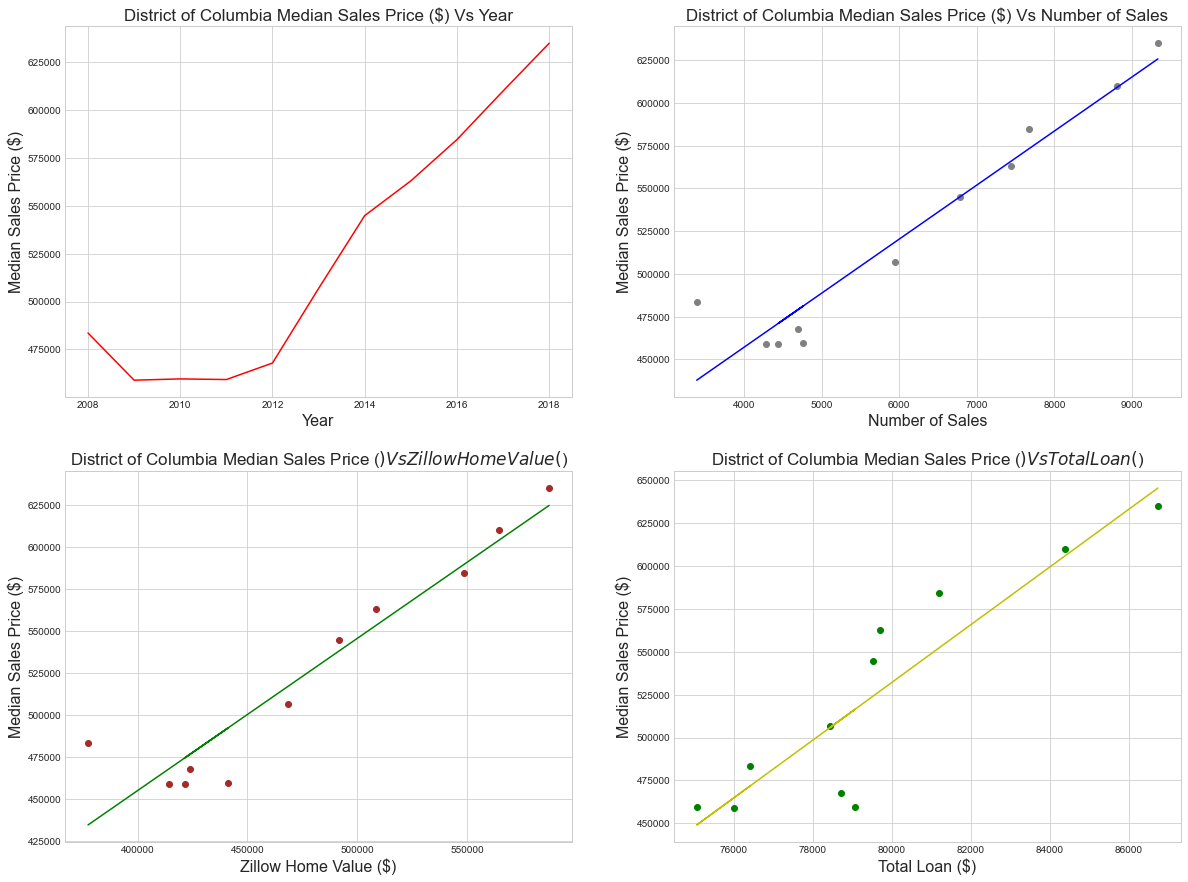

California's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)    0.992635
Unemployment Rate (%)    0.935783
Divorce Rate (%)         0.912950
Student Loan ($)         0.751412
Name: Median Sales Price ($), dtype: float64


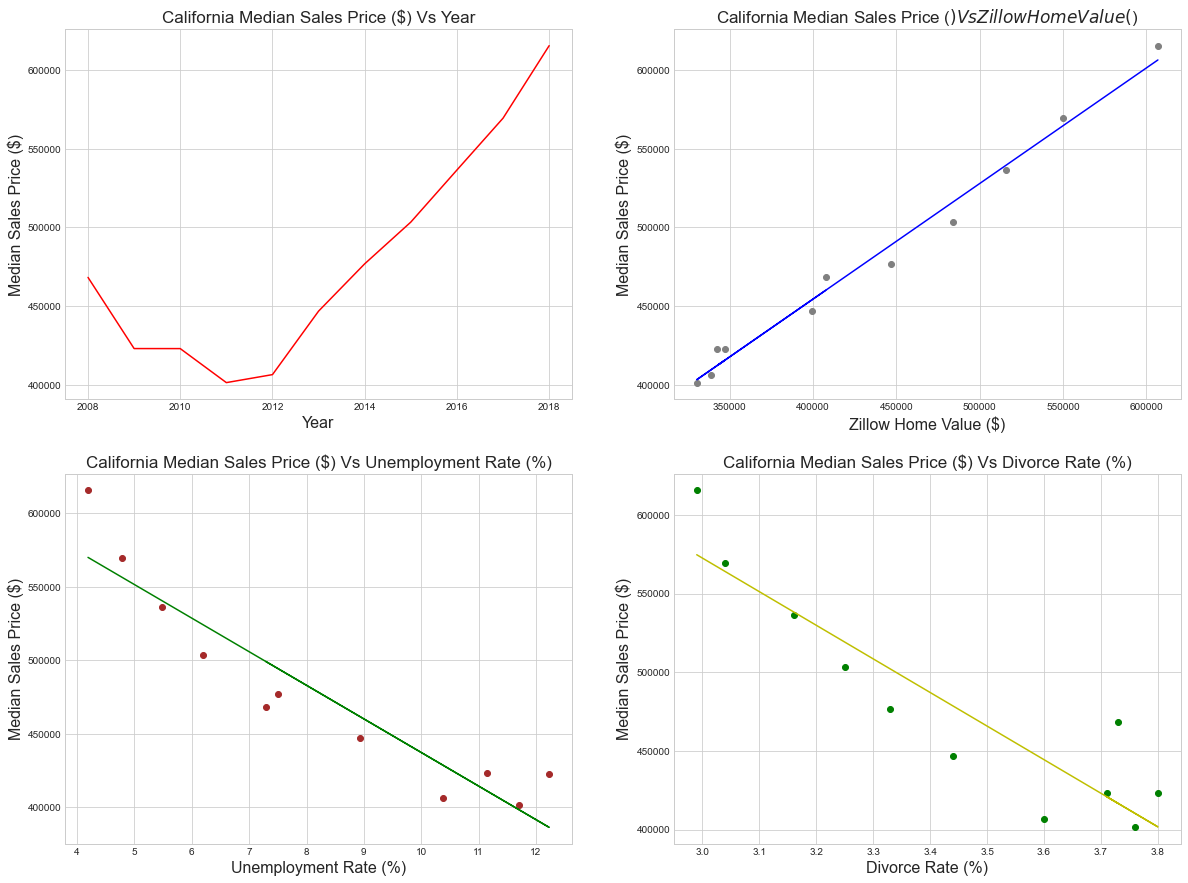

Colorado's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)    0.987163
Divorce Rate (%)         0.973669
Median Income ($)        0.922247
Unemployment Rate (%)    0.886504
Name: Median Sales Price ($), dtype: float64


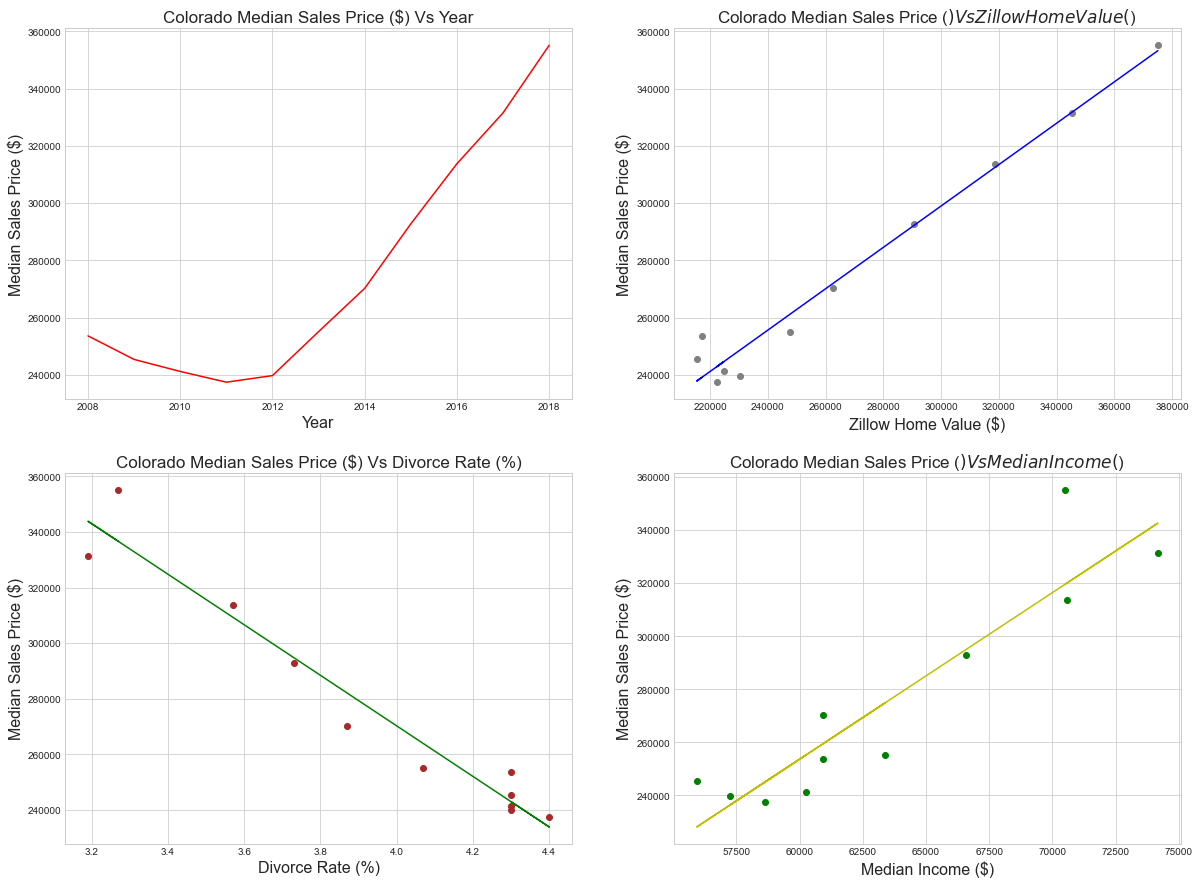

Washington's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)    0.963539
Median Income ($)        0.825883
Unemployment Rate (%)    0.769209
Divorce Rate (%)         0.754855
Name: Median Sales Price ($), dtype: float64


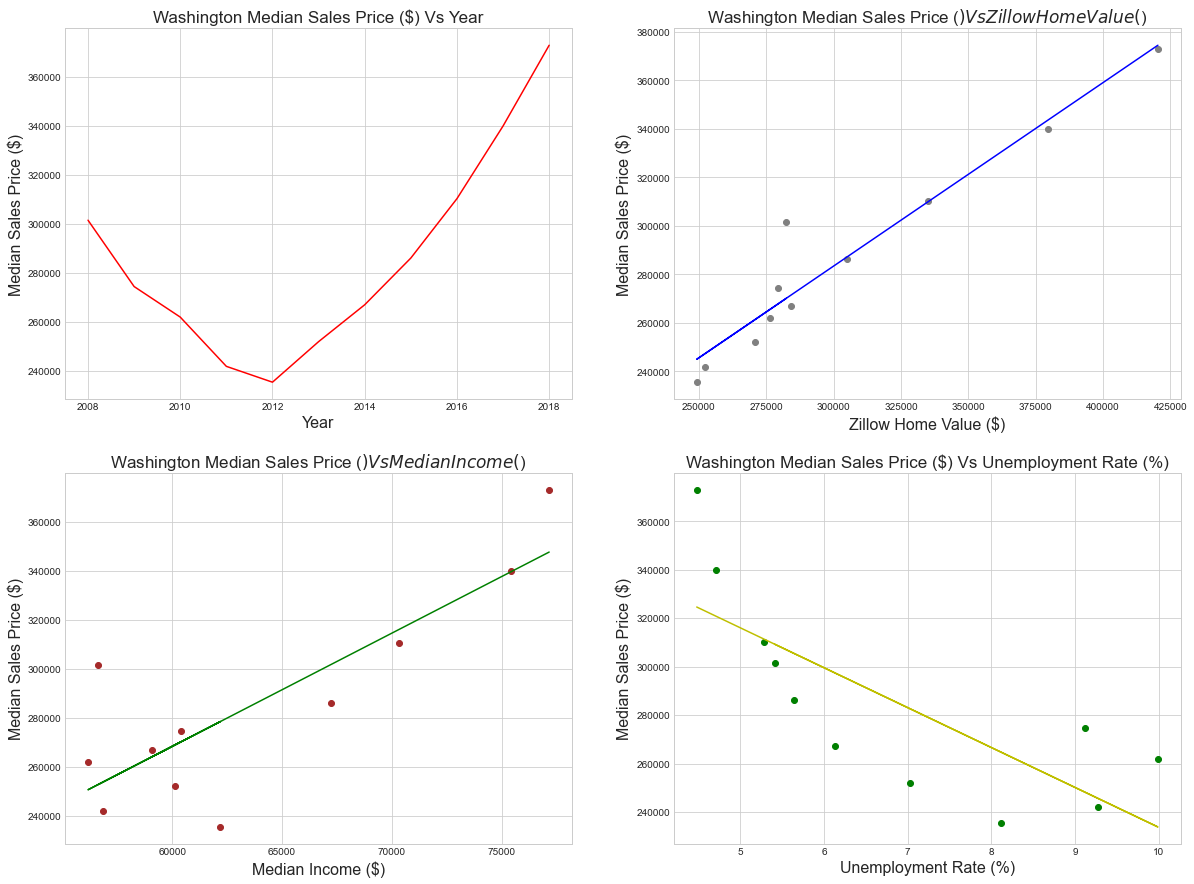

Massachusetts's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)    0.962150
Unemployment Rate (%)    0.905279
Number of Sales          0.843017
Total Loan ($)           0.815680
Name: Median Sales Price ($), dtype: float64


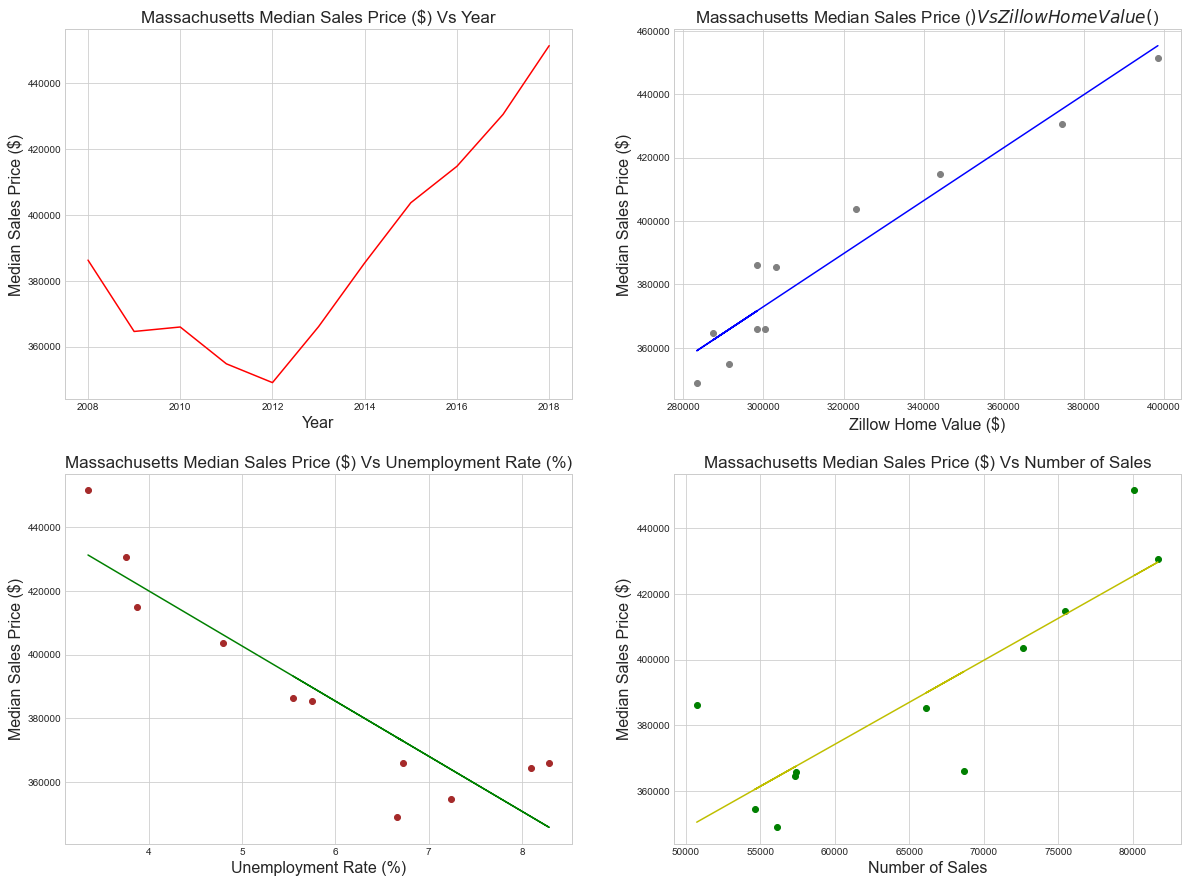

[None, None, None, None, None]

In [50]:
# Show Strongest Pearson Correlation Factors for top 5 states with greatest increase in MSR
greatest_increase = ["DC","CA","CO","WA","MA"]
[showStatedata(x) for x in greatest_increase]

Connecticut's Strongest Pearson Correlation Factors
---------------------------------------------------
Total Loan ($)       0.733368
Divorce Rate (%)     0.637433
Student Loan ($)     0.634021
Median Income ($)    0.397807
Name: Median Sales Price ($), dtype: float64


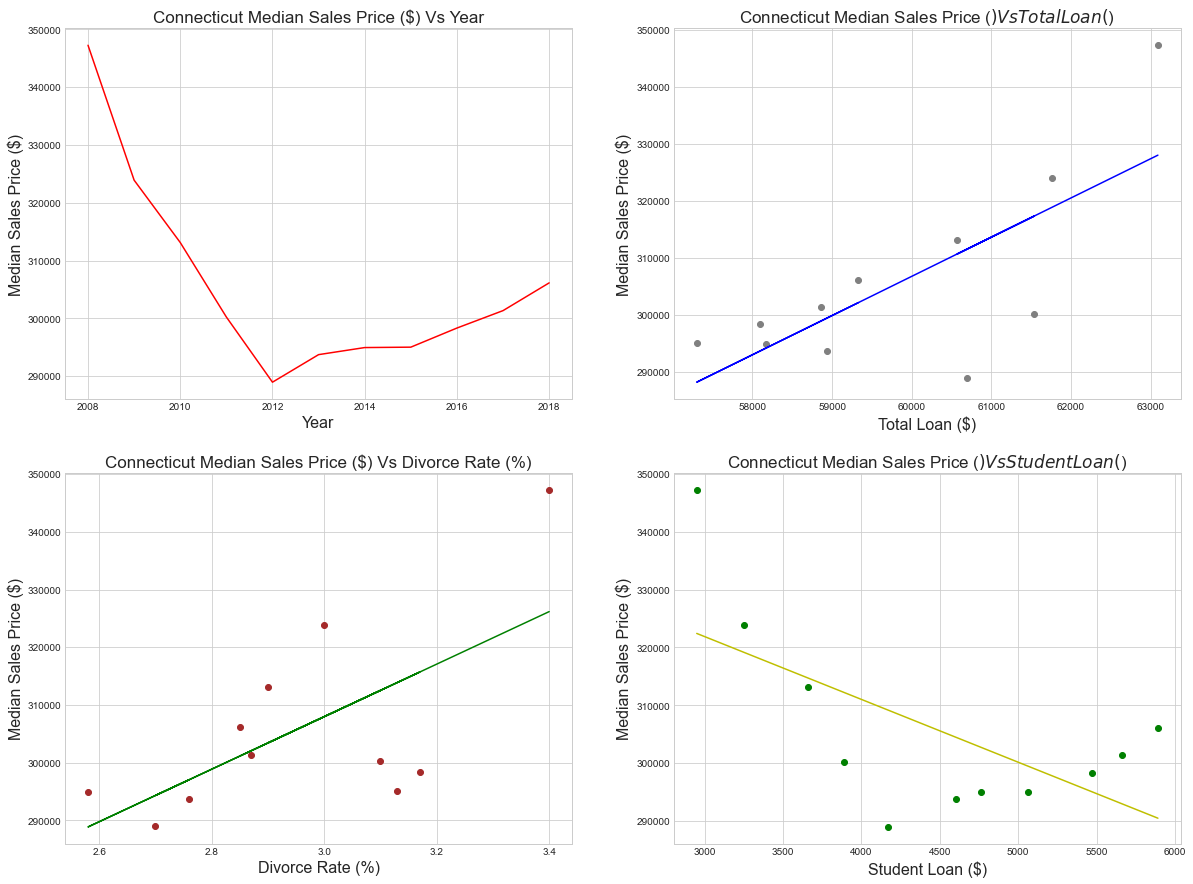

New Jersey's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)    0.922704
Total Loan ($)           0.501883
Unemployment Rate (%)    0.395383
Student Loan ($)         0.379391
Name: Median Sales Price ($), dtype: float64


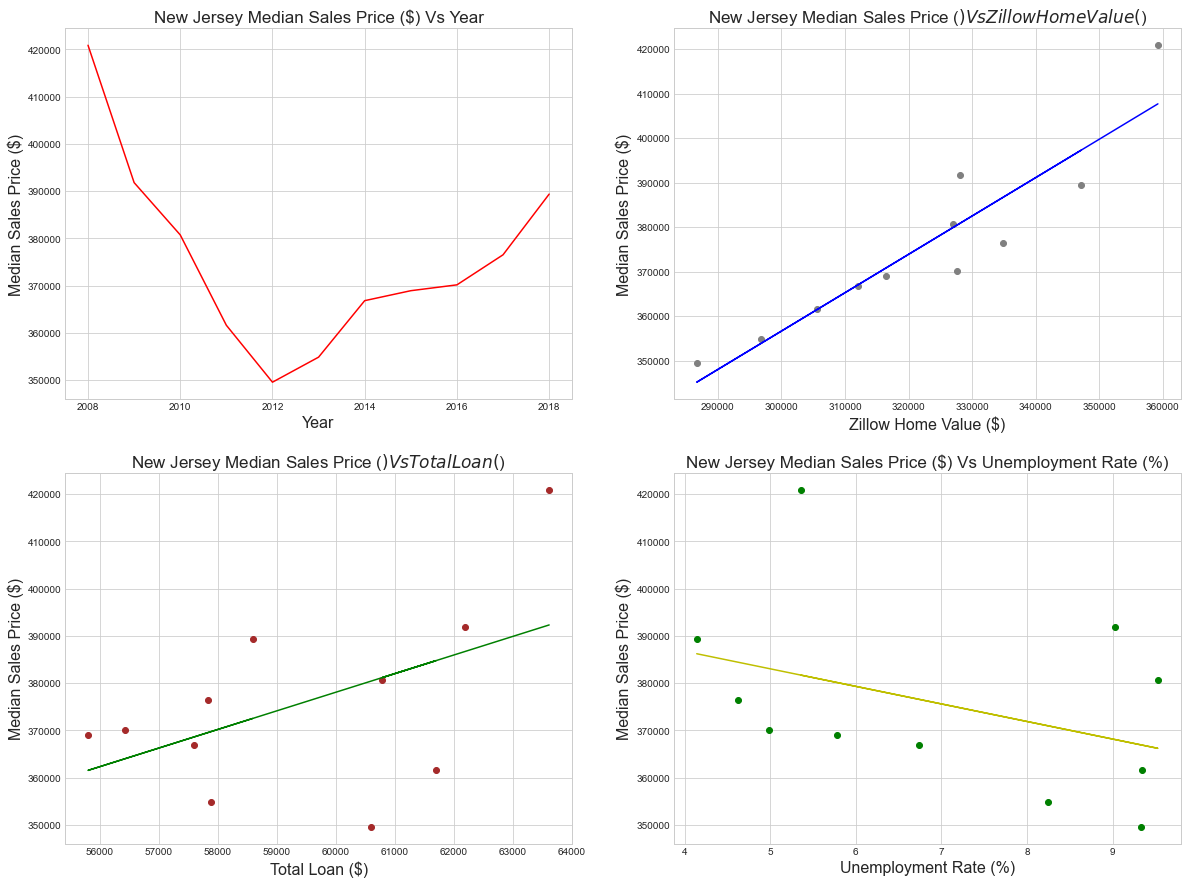

Maryland's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)      0.779547
Total Loan ($)             0.776818
Unemployment Rate (%)      0.652607
Foreclosure Resales (%)    0.473501
Name: Median Sales Price ($), dtype: float64


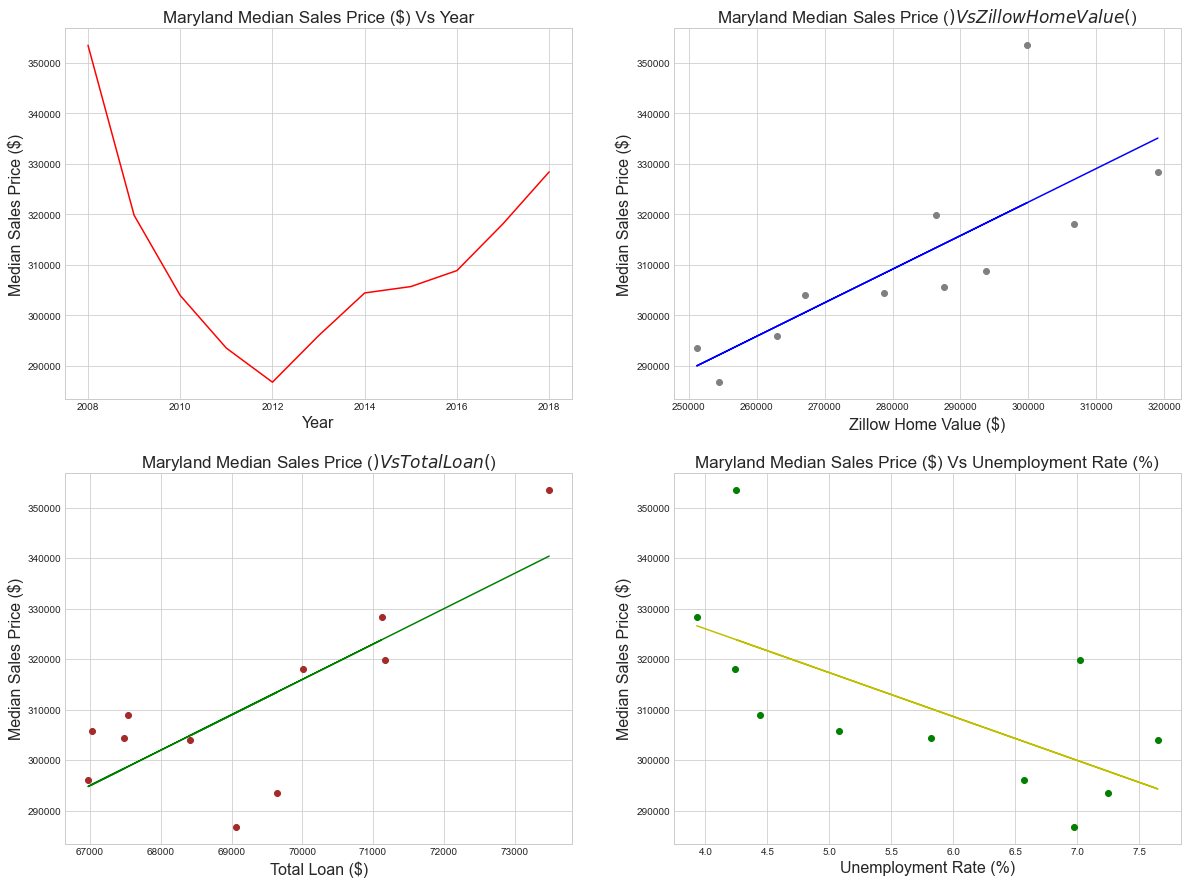

New Mexico's Strongest Pearson Correlation Factors
---------------------------------------------------
Zillow Home Value ($)    0.878628
Total Loan ($)           0.865933
Student Loan ($)         0.837721
Divorce Rate (%)         0.797318
Name: Median Sales Price ($), dtype: float64


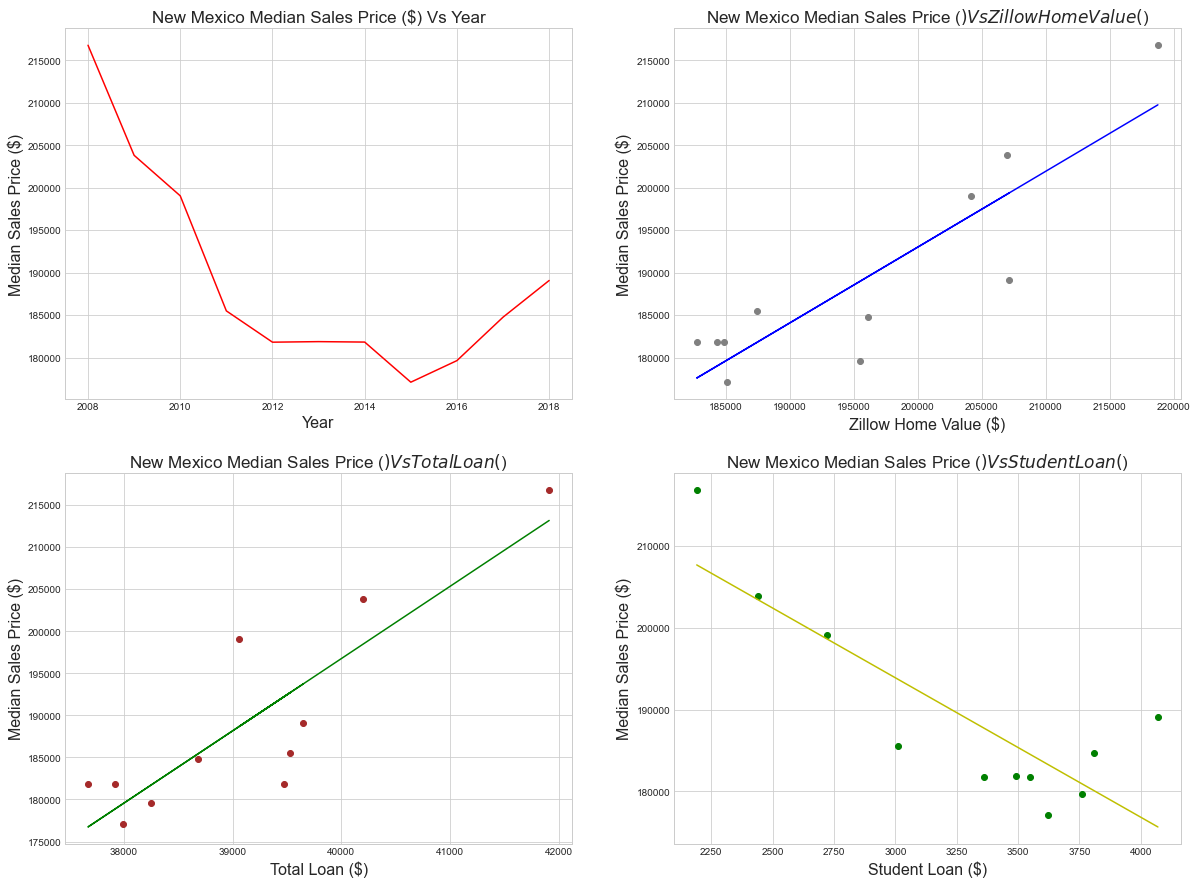

West Virginia's Strongest Pearson Correlation Factors
---------------------------------------------------
Student Loan ($)         0.963852
Total Loan ($)           0.903586
Zillow Home Value ($)    0.863968
Divorce Rate (%)         0.835888
Name: Median Sales Price ($), dtype: float64


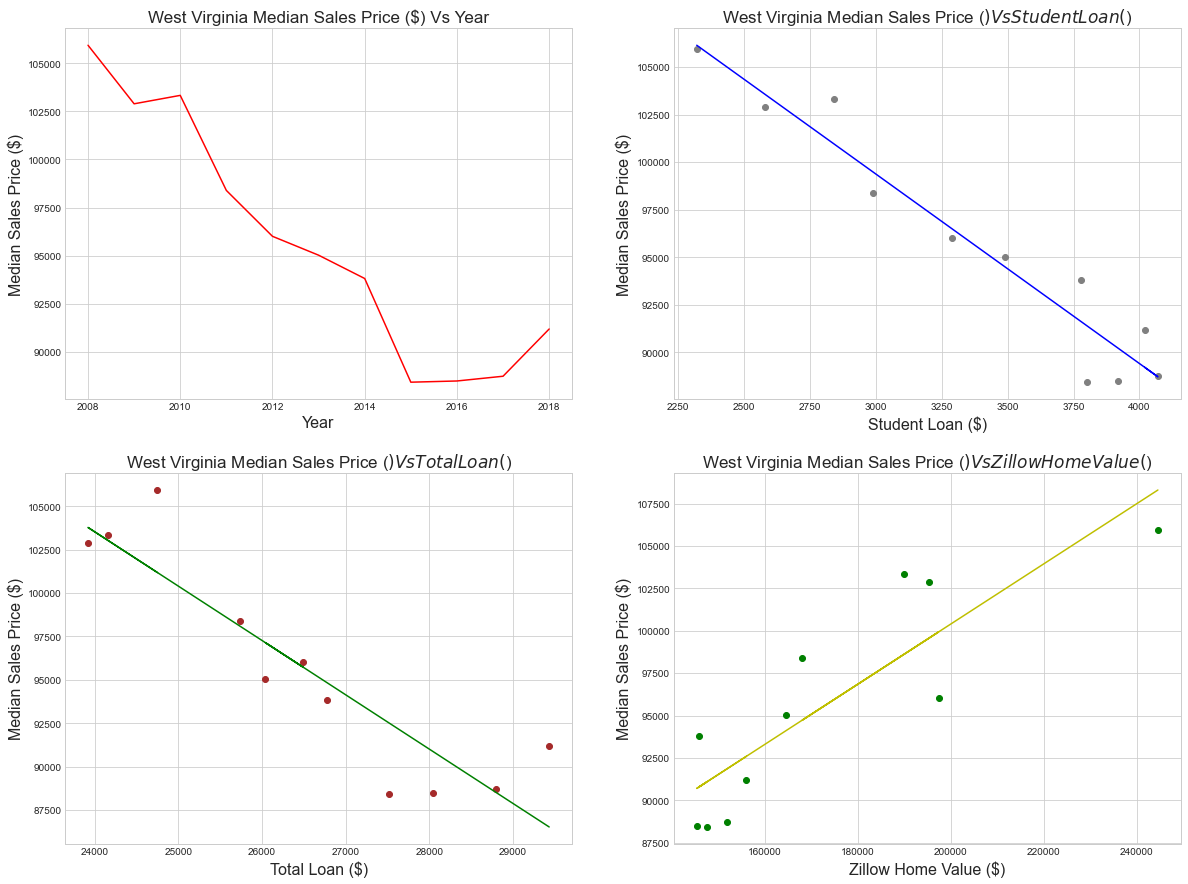

[None, None, None, None, None]

In [51]:
# Show Strongest Pearson Correlation Factors for top 5 states with greatest decrease in MSR
greatest_decrease = ["CT","NJ","MD","NM","WV"]
[showStatedata(x) for x in greatest_decrease]

In [55]:
def predictmsr(data):
    # Transpose data to make states the columns
    x = massive_data.T
    # Take user input and uppercase it
    state = str(data).upper()
    # Get column corresponding to that psrticular state
    ak = x[state]
    # Get the values of all years in that suffix 
    i = 0
    vim = list(range(9))
    for x in vim:
        vim[x] = ak.iloc[i:i+11]
        i += 11
    # Get full name of the state by state code
    state_keys = list(us_state_abbrev.keys())
    state_values = list(us_state_abbrev.values())
    name_state = state_keys[state_values.index(state)]
    columns = ["MSR","ZHVI","NS","FR","Divorce Rate","Unemployment Rate","Student Loan","Total Loan", "Median Income"]
    gather_concat = list(range(9))
    year = pd.DataFrame({"Year":[2008, 2009, 2010, 2011,
                                2012,2013,2014,2015,2016,2017,2018]})
    # Create a list of dataframes for each suffix
    for i in gather_concat:
        gather_concat[i] = pd.DataFrame({columns[i]:vim[i]}).reset_index()[columns[i]]
    # Create a generic dataframe for that particular state using year to index
    state_df = pd.concat(
                [year,gather_concat[0],gather_concat[1],gather_concat[2],
                 gather_concat[3],gather_concat[4],gather_concat[5],
                 gather_concat[6],gather_concat[7],gather_concat[8]], 
                 axis=1, sort=False
    ).set_index("Year")
    # Fill NA by average, change name of columns
    state_df.fillna(state_df.mean(), inplace=True)
    # Rename the columns
    state_df = state_df.rename(columns={
                    "ZHVI":"Zillow Home Value ($)",
                    "MSR":"Median Sales Price ($)",
                    "NS":"Number of Sales",
                    "FR":"Foreclosure Resales (%)",
                    "Divorce Rate": "Divorce Rate (%)",
                    "Unemployment Rate": "Unemployment Rate (%)",
                    "Student Loan": "Student Loan ($)",
                    "Total Loan": "Total Loan ($)",
                    "Median Income": "Median Income ($)"
                })
    #print(state_df.corr())
    # Avoid duplicate and self correlations and proper sorting
    cor = state_df.corr()["Median Sales Price ($)"][:].abs().sort_values(ascending=False)[1:5]
    corr = pd.DataFrame(cor).index
    corr_df = state_df[corr]    
    
    print(f'The strongest factors that correlate with {name_state} are: {corr_df.iloc[:,0].name} , {corr_df.iloc[:,1].name} and {corr_df.iloc[:,2].name}')
    time.sleep(1)
    response = input("Would you like to run a regression?  ").upper()
    time.sleep(1)
    try:
        if (response == "YES") or (response == "Y") or (response == "YEAH") or (response == "YUP"):
            ## Convert to floats and store x and y values
            X = pd.DataFrame({corr_df.index.name:corr_df.index, 
                              corr_df.iloc[:,0].name:corr_df.iloc[:,0], 
                              corr_df.iloc[:,1].name:corr_df.iloc[:,1]})
            Y = state_df["Median Sales Price ($)"]
            # with sklearn run linear regression
            regr = linear_model.LinearRegression()
            regr.fit(X, Y)
            print(f"RUNNING MULTIPLE REGRESSION ON {name_state.upper()}")
            print("--------------------------------------------------------")
            time.sleep(1)
            print('Intercept: \n', regr.intercept_)
            print('Coefficients: \n', regr.coef_)
            # Take first user input based on highest correlation
            first =float(input(f'Type {X.iloc[:,0].name}:  '))
            # Take second user input based on highest correlation
            time.sleep(0.5)
            second =float(input(f'Type {X.iloc[:,1].name}:  '))
            # Take third user input based on highest correlation
            time.sleep(0.5)
            third = float(input(f'Type {X.iloc[:,2].name}:  '))
            # Run regression based on first, second and third input
            regr = round(int(regr.predict([[first ,second, third]])),2)
            time.sleep(1)
            print(f'Predicted {name_state} Median Sales Price: ${regr:,}')
        if (response == "NO") or (response == "N") or (response == 'NOP') or (response == 'NAH'):
            print("Goodbye!")
    except:
        print("Enter a valid response!")
        pass

In [57]:
# Predict California MSR for any year based on strongest Correlation factors
predictmsr("dc")

The strongest factors that correlate with District of Columbia are: Number of Sales , Zillow Home Value ($) and Total Loan ($)
RUNNING MULTIPLE REGRESSION ON DISTRICT OF COLUMBIA
--------------------------------------------------------
Intercept: 
 10380295.696209943
Coefficients: 
 [-4.98622233e+03  4.77040655e+01 -2.33055664e-01]
Predicted District of Columbia Median Sales Price: $698,462
